In [ ]:
!pip install -U efficientnet
!pip install tensorflow-addons

     |████████████████████████████████| 50 kB 2.5 MB/s 
     |████████████████████████████████| 1.1 MB 4.1 MB/s 


## Import

In [ ]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

import efficientnet
import efficientnet.tfkeras as efn

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow.keras as keras
from tensorflow.data import Dataset

import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Pre-processing

In [ ]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    for case_name in os.listdir(data_dir):
        current_path = os.path.join(data_dir, case_name)
        if os.path.isdir(current_path):
            # get image path
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.jpg')))
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.png')))
            
            # get label
            label_df = pd.read_csv(current_path+'/label.csv')
            label_list.extend(label_df['leaf_weight'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    # get image path
    img_path_list = glob(os.path.join(data_dir, 'image', '*.jpg'))
    img_path_list.extend(glob(os.path.join(data_dir, 'image', '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    return img_path_list

In [ ]:
def load_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0 # normalize 
    return img

In [ ]:
def create_dataset(img_dir, label, target_size, batch_size=None) :    
    img = [] # 원본이미지
    
    ## 최적화가 필요한 부분
    for i in img_dir:
        image = load_img_numpy(i, target_size)
        img.append(image)
        
    x = Dataset.from_tensor_slices(img)
    y = Dataset.from_tensor_slices(label)
    dataset = Dataset.zip((x, y))
    
    if batch_size is not None:
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
   
    return dataset

In [ ]:
def load_test_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0
    return img

def create_test_dataset(img_dir, target_size, batch_size=None) :
    file_name = [x.split('/')[-1][:-4] for x in img_dir]
    x_img = []

    for i in tqdm(img_dir,
                total=len(img_dir),
                position=0,
                leave=True):
        img = load_test_img_numpy(i, target_size)
        x_img.append(img)

    dataset = Dataset.from_tensor_slices(x_img)
    
    if batch_size is not None :
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
       
    return dataset, file_name

## Load Data Set

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 8
LEARNING_RATE = 5e-5

all_img_path, all_label = get_train_data('/content/drive/MyDrive/project/deep learning_data/open/train')
test_img_path = get_test_data('/content/drive/MyDrive/project/deep learning_data/open/test')

## Train / Validation Split

In [ ]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(all_img_path)*0.8)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [ ]:
train_dataset = create_dataset(train_img_path, train_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE)
valid_dataset = create_dataset(vali_img_path, vali_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE )

In [ ]:
train_dataset

<RepeatDataset element_spec=(TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.float32, name=None))>

In [ ]:
valid_dataset

<RepeatDataset element_spec=(TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.float32, name=None))>

## EfficientNetB7 Model

In [ ]:
base_model = efn.EfficientNetB7(
    weights='imagenet',
    include_top = False,
    input_shape = (IMAGE_SIZE,IMAGE_SIZE) + (3,)
)
base_model.summary()

258449408/258434480 [==============================] - 22s 0us/step
Model: "efficientnet-b7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 64  256         ['stem_conv[0][0]']              
                

In [ ]:
from tensorflow.keras.regularizers import *

LAMBDA_VAL = 0.001

base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D()) # Flatten??
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer=L2(l2=LAMBDA_VAL)))
model.add(Dense(1, activation='linear', kernel_regularizer=L2(l2=LAMBDA_VAL)))

# Early Stopping
es = EarlyStopping(monitor='val_loss',
                   mode='auto',
                   patience=5,
                   verbose=1)

# Checkpoint
# model_checkpoint = './{epoch:06d}-{val_acc:0.6f}-{acc:0.6f}.ckpt'

# checkpointer = ModelCheckpoint(
#     filepath=model_checkpoint,
#     verbose=1,
#     period=2,
#     save_best_weights=True,
#     mode='auto',
#     monitor='val_acc'
# )



In [ ]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mse',
              metrics=['mae'])


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    # callbacks=[es, checkpointer],
                    verbose=1)

model.save('./pretrained_model_efficentnetb7.h5')

Epoch 1/30
159/159 [==============================] - 850s 5s/step - loss: 16632.2227 - mae: 76.7372 - val_loss: 15296.5781 - val_mae: 80.1640
Epoch 2/30
159/159 [==============================] - 849s 5s/step - loss: 15641.6992 - mae: 73.3520 - val_loss: 14181.7002 - val_mae: 77.0606
Epoch 3/30
159/159 [==============================] - 829s 5s/step - loss: 14743.9043 - mae: 71.2398 - val_loss: 13158.8613 - val_mae: 74.8890
Epoch 4/30
159/159 [==============================] - 829s 5s/step - loss: 13927.5264 - mae: 69.8415 - val_loss: 12243.7168 - val_mae: 73.3329
Epoch 5/30
159/159 [==============================] - 834s 5s/step - loss: 13349.7764 - mae: 69.4522 - val_loss: 11452.0869 - val_mae: 72.2177
Epoch 6/30
159/159 [==============================] - 838s 5s/step - loss: 12715.6367 - mae: 69.0052 - val_loss: 10782.3379 - val_mae: 71.3978
Epoch 7/30
159/159 [==============================] - 832s 5s/step - loss: 12133.8184 - mae: 69.2672 - val_loss: 10225.1885 - val_mae: 70.7602

Text(0.5, 1.0, 'Training and Validation MAE')

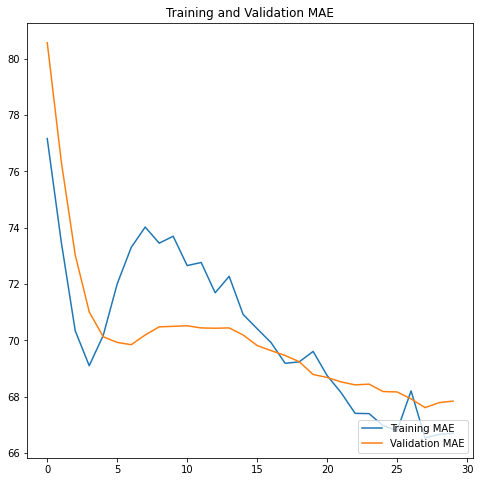

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## Fine-tuning


In [ ]:
base_model.trainable=False
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  806


In [ ]:
fine_tune_at= 400

for i, layer in enumerate(base_model.layers[:fine_tune_at]):
    if 'bn' not in layer.name :
        layer.trainable = True

In [ ]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mse',
              metrics=['mae'])

In [ ]:
FINE_TUNE_EPOCHS = 30 
history = model.fit(train_dataset, epochs=FINE_TUNE_EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    # callbacks=[es, checkpointer],
                    verbose=1)

model.save('./fine_tuned_model.h5')

Epoch 1/30
159/159 [==============================] - 84s 409ms/step - loss: 8694.8887 - mae: 67.0456 - val_loss: 7250.4189 - val_mae: 67.8105
Epoch 2/30
159/159 [==============================] - 60s 376ms/step - loss: 8765.8408 - mae: 67.0295 - val_loss: 7249.8301 - val_mae: 67.8046
Epoch 3/30
159/159 [==============================] - 60s 376ms/step - loss: 8654.6006 - mae: 66.3333 - val_loss: 7249.1875 - val_mae: 67.7896
Epoch 4/30
159/159 [==============================] - 69s 434ms/step - loss: 8432.7646 - mae: 65.3914 - val_loss: 7249.3110 - val_mae: 67.7824
Epoch 5/30
159/159 [==============================] - 60s 376ms/step - loss: 8678.2646 - mae: 66.3434 - val_loss: 7251.4824 - val_mae: 67.8029
Epoch 6/30
159/159 [==============================] - 60s 375ms/step - loss: 8481.9346 - mae: 65.7978 - val_loss: 7251.4653 - val_mae: 67.7809
Epoch 7/30
159/159 [==============================] - 69s 434ms/step - loss: 8690.1719 - mae: 66.8349 - val_loss: 7250.8999 - val_mae: 67.7609

Text(0.5, 1.0, 'Training and Validation fine-tuning MAE')

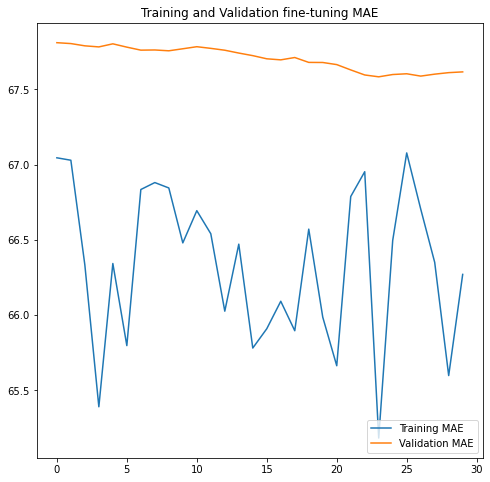

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation fine-tuning MAE')

In [ ]:
history = model.fit(train_dataset, epochs=30,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    # callbacks=[es, checkpointer],
                    verbose=1)

model.save('./fine_tuned_model_continue.h5')

Epoch 1/30
159/159 [==============================] - 58s 366ms/step - loss: 8702.4268 - mae: 66.6529 - val_loss: 7249.0601 - val_mae: 67.6084
Epoch 2/30
159/159 [==============================] - 59s 369ms/step - loss: 8735.0234 - mae: 66.5163 - val_loss: 7250.1187 - val_mae: 67.6203
Epoch 3/30
159/159 [==============================] - 59s 370ms/step - loss: 8563.4580 - mae: 65.8740 - val_loss: 7251.0786 - val_mae: 67.6351
Epoch 4/30
159/159 [==============================] - 59s 369ms/step - loss: 8509.9404 - mae: 66.0242 - val_loss: 7251.4985 - val_mae: 67.6323
Epoch 5/30
159/159 [==============================] - 59s 369ms/step - loss: 8565.7051 - mae: 66.0988 - val_loss: 7251.7422 - val_mae: 67.6263
Epoch 6/30
159/159 [==============================] - 59s 369ms/step - loss: 8567.8623 - mae: 66.3104 - val_loss: 7249.8799 - val_mae: 67.5947
Epoch 7/30
159/159 [==============================] - 59s 369ms/step - loss: 8604.8555 - mae: 66.4065 - val_loss: 7251.0649 - val_mae: 67.5982

Text(0.5, 1.0, 'Training and Validation MAE')

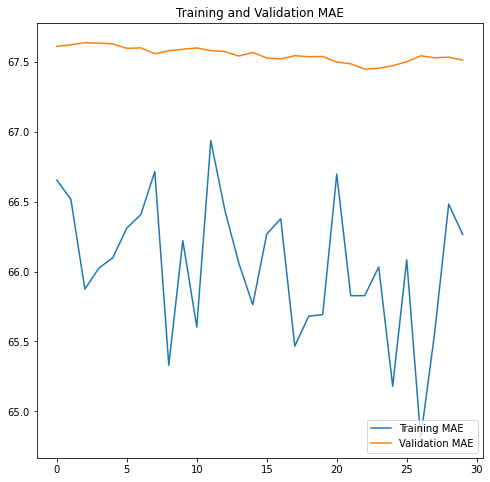

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## CustomDataset

---


## 규제 없는 모델
&loss = mae

In [ ]:
base_model.trainable = False
model2 = Sequential()
model2.add(base_model)
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='linear'))

checkpoint_filepath = './no_regul_pretrain_best_model.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

model2.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

NameError: ignored

In [ ]:
history2 = model2.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 76.5200 - mae: 76.5200
Epoch 1: val_mae improved from inf to 79.46751, saving model to ./no_regul_pretrain_best_model.h5
159/159 [==============================] - 86s 416ms/step - loss: 76.5200 - mae: 76.5200 - val_loss: 79.4675 - val_mae: 79.4675
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 72.8575 - mae: 72.8575
Epoch 2: val_mae improved from 79.46751 to 76.19594, saving model to ./no_regul_pretrain_best_model.h5
159/159 [==============================] - 60s 381ms/step - loss: 72.8575 - mae: 72.8575 - val_loss: 76.1959 - val_mae: 76.1959
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 70.9478 - mae: 70.9478
Epoch 3: val_mae improved from 76.19594 to 74.24055, saving model to ./no_regul_pretrain_best_model.h5
159/159 [==============================] - 61s 383ms/step - loss: 70.9478 - mae: 70.9478 - val_loss: 74.2405 - val_mae: 74.2405
Epoch 4/30
159/159 [=============

Text(0.5, 1.0, 'Training and Validation MAE')

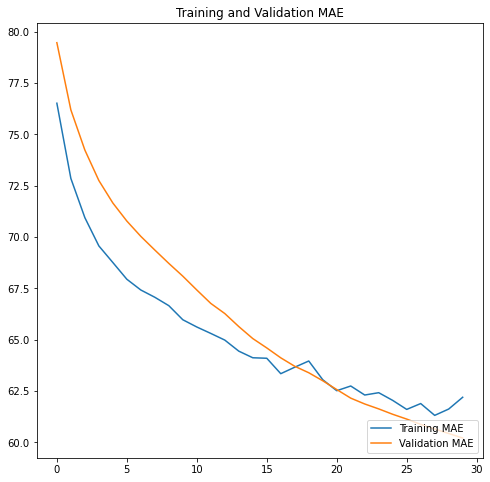

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history2.history['mae'], label='Training MAE')
plt.plot(history2.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## fine tune

In [ ]:
for i, layer in enumerate(base_model.layers[:fine_tune_at]):
    if 'bn' not in layer.name :
        layer.trainable = True

In [ ]:
model2.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mae',
              metrics=['mae'])

checkpoint_filepath = './no_regul_finetune_best_model.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

history2 = model2.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

model2.save('./by_chance_noregul_finetunemoedl.h5')

NameError: ignored

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history2.history['mae'], label='Training MAE')
plt.plot(history2.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

NameError: ignored

<Figure size 576x576 with 0 Axes>

In [ ]:
checkpoint_filepath = './no_regul_finetune_best_model_add_epoch.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

history2 = model2.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

model2.save('./by_chance_noregul_finetunemoed_plus.h5')

## learning rate 변경

In [ ]:
 base_model = efn.EfficientNetB4(
    weights='imagenet',
    include_top = False,
    input_shape = (IMAGE_SIZE,IMAGE_SIZE) + (3,)
)

In [ ]:
LAMBDA_VAL = 0.001
LEARNING_RATE = 1e-4

base_model.trainable = False
model3 = Sequential()
model3.add(base_model)
model3.add(GlobalAveragePooling2D()) # Flatten??
model3.add(Dropout(0.3))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1, activation='linear'))

checkpoint_filepath = '/content/drive/MyDrive/project/no_regul_pretrain_best_model.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

model3.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [ ]:
history3 = model3.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)


In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history3.history['mae'], label='Training MAE')
plt.plot(history3.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## finetune

In [ ]:
fine_tune_at= 400

for i, layer in enumerate(base_model.layers[:fine_tune_at]):
    if 'bn' not in layer.name :
        layer.trainable = True

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/project/no_regul_pretrain_best_model.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

model3.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mae',
              metrics=['mae'])

history3 = model3.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history3.history['mae'], label='Training MAE')
plt.plot(history3.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## Prediction

In [ ]:
len(test_img_path)

In [ ]:
PRED_BATCH_SIZE = 10

In [ ]:
test_dataset, file_names = create_test_dataset(test_img_path, (IMAGE_SIZE, IMAGE_SIZE), PRED_BATCH_SIZE )

In [ ]:
eff_model = tf.keras.models.load_model('/content/drive/MyDrive/AI_proj/no_regul_pretrain_best_model.h5')

STEPS = len(test_img_path) / PRED_BATCH_SIZE
prediction = eff_model.predict(test_dataset,
                            batch_size = PRED_BATCH_SIZE,
                            steps=STEPS)


## Submission

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Colab 폴더/deep learning_data/open/sample_submission.csv')
submission['leaf_weight'] = preds
submission.to_csv('./submit_.csv', index=False)


